In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logictensornetworks as ltn
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/git/Papers_LTN-DNN_code_git/datesets/Cantilever/training_sectiune/tot.csv", on_bad_lines='skip', skiprows=1)
df = df.sample(frac=1) #shuffle
print(df.shape)

(36573, 11)


In [3]:
df.drop_duplicates(keep= 'first', inplace=True) #eliminarea dublurilor liniilor
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace = True)
print('Null values in dataset are',len(df[df.isnull().any(1)]))
df.shape

Null values in dataset are 0


(36573, 11)

In [4]:
X = df[['Mod 1', 'Mod 2','Mod 3','Mod 4','Mod 5','Mod 6','Mod 7','Mod 8']].values
y = df[['Severitate def', 'Severitate inc.','Pozitie']].values
train_labels = ['Mod 1', 'Mod 2','Mod 3','Mod 4','Mod 5','Mod 6','Mod 7','Mod 8']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [6]:
sample_size = X_train.shape[0]
time_steps = X_train.shape[1]
input_dimensions = 1

X_train_reshaped = X_train.reshape(sample_size, time_steps, input_dimensions)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print("After reshape train date set shape:\n", X_train_reshaped.shape)
print("1 Sample shape:\n", X_train_reshaped[0].shape)
print("An example sample:\n", X_train_reshaped[0])

After reshape train date set shape:
 (34744, 8, 1)
1 Sample shape:
 (8, 1)
An example sample:
 [[0.0071211 ]
 [0.03407706]
 [0.00037453]
 [0.0326655 ]
 [0.00064594]
 [0.03212929]
 [0.00136208]
 [0.03130075]]


In [7]:
batch_size = 2000
ds_train = tf.data.Dataset.from_tensor_slices((X_train_reshaped,y_train)).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((X_test_reshaped,y_test)).batch(batch_size)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-06-15 22:09:40.813643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-15 22:09:40.814196: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
import keras
def build_conv1D_model():

    n_timesteps = X_train_reshaped.shape[1] #13
    n_features  = X_train_reshaped.shape[2] #1 
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu', name="Conv1D_1"))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
  
    model.add(keras.layers.Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3"))
  
    model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(8, activation='relu', name="Dense_1"))
    model.add(keras.layers.Dense(3, name="Dense_2"))

    return model

# logits_model = build_conv1D_model()
# f = ltn.Predicate(ltn.utils.LogitsToPredicateModel(logits_model,single_label=True))
# logits_model.summary()
model_conv = build_conv1D_model()
model_conv.summary()
f = ltn.Function(model_conv)

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 5, 64)             320       
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 3, 32)             6176      
                                                                 
 Conv1D_3 (Conv1D)           (None, 2, 16)             1040      
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 1, 16)            0         
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 Dense_1 (Dense)             (None, 8)                

In [9]:
eq = ltn.Predicate.Lambda(
    lambda args: tf.exp(-0.05*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))        
    #lambda args: 1/(1+0.5*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))
)

In [10]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=2),semantics="exists")

In [11]:
@tf.function
def axioms(x_data, y_data):
    x = ltn.Variable("x", x_data)
    y = ltn.Variable("y", y_data)
    return Forall(ltn.diag(x,y), eq([f(x),y])).tensor

In [12]:
for x, y in ds_test:
    print("Initial sat level %.5f"%axioms(x,y))
    break

Initial sat level 0.97174


2023-06-15 22:09:50.020523: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-15 22:09:50.021194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [13]:
metrics_dict = {
    'train_sat': tf.keras.metrics.Mean(name='train_sat'),
    'test_sat': tf.keras.metrics.Mean(name='test_sat'),
    'train_accuracy': tf.keras.metrics.RootMeanSquaredError(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.RootMeanSquaredError(name="test_accuracy")
}

In [14]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
@tf.function
def train_step(x, y):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(x, y)
        loss = 1.-sat
    gradients = tape.gradient(loss, f.trainable_variables)
    optimizer.apply_gradients(zip(gradients, f.trainable_variables))
    sat = axioms(x, y)
    metrics_dict['train_sat'](sat)
    # accuracy
    metrics_dict['train_accuracy'](y,f.model(x))
    
@tf.function
def test_step(x, y):
    # sat
    sat = axioms(x, y)
    metrics_dict['test_sat'](sat)
    # accuracy
    metrics_dict['test_accuracy'](y,f.model(x))

In [15]:
from collections import defaultdict
import time

def train(
        epochs,
        metrics_dict, 
        ds_train, 
        ds_test, 
        train_step, 
        test_step,
        track_metrics=1,
        csv_path=None,
        scheduled_parameters=defaultdict(lambda : {})
    ):
    
    template = "Epoch {}"
    for metrics_label in metrics_dict.keys():
        template += ", %s: {:.4f}" % metrics_label

    if csv_path is not None:
        csv_file = open(csv_path,"w+")
        headers = ",".join(["Epoch"]+list(metrics_dict.keys()))
        csv_template = ",".join(["{}" for _ in range(len(metrics_dict)+1)])
        csv_file.write(headers+"\n")
    
    epoch_times = []
    start_time = time.time()
    
    for epoch in range(epochs):
        for metrics in metrics_dict.values():
            metrics.reset_states()

        for batch_elements in ds_train:
            train_step(*batch_elements,**scheduled_parameters[epoch])

        for batch_elements in ds_test:
            test_step(*batch_elements,**scheduled_parameters[epoch])

        metrics_results = [metrics.result() for metrics in metrics_dict.values()]
        if epoch%track_metrics == 0:
            print(template.format(epoch,*metrics_results))
        
        if csv_path is not None:
            csv_file.write(csv_template.format(epoch,*metrics_results)+"\n")
            csv_file.flush()

        end_time = time.time()
        epoch_time = end_time - start_time
        start_time = end_time
        epoch_times.append(epoch_time)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Time: {epoch_time}")

    if csv_path is not None:
        csv_file.close()
        
    return epoch_times


In [16]:
EPOCHS = 2000

epoch_times = train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path="final.csv",
    track_metrics=20
)

2023-06-15 22:09:57.728522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-06-15 22:09:58.536363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-06-15 22:09:58.985850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 0, train_sat: 0.9798, test_sat: 0.9853, train_accuracy: 0.2442, test_accuracy: 0.1702
Epoch 0, Time: 1.639312744140625
Epoch 10, Time: 0.2701737880706787
Epoch 20, train_sat: 0.9869, test_sat: 0.9868, train_accuracy: 0.1523, test_accuracy: 0.1533
Epoch 20, Time: 0.25044989585876465
Epoch 30, Time: 0.25257110595703125
Epoch 40, train_sat: 0.9893, test_sat: 0.9895, train_accuracy: 0.1244, test_accuracy: 0.1209
Epoch 40, Time: 0.25357913970947266
Epoch 50, Time: 0.24973320960998535
Epoch 60, train_sat: 0.9911, test_sat: 0.9914, train_accuracy: 0.1028, test_accuracy: 0.0991
Epoch 60, Time: 0.2628040313720703
Epoch 70, Time: 0.243117094039917
Epoch 80, train_sat: 0.9921, test_sat: 0.9924, train_accuracy: 0.0908, test_accuracy: 0.0872
Epoch 80, Time: 0.24231624603271484
Epoch 90, Time: 0.24110984802246094
Epoch 100, train_sat: 0.9929, test_sat: 0.9931, train_accuracy: 0.0821, test_accuracy: 0.0791
Epoch 100, Time: 0.24841618537902832
Epoch 110, Time: 0.2398841381072998
Epoch 120, train

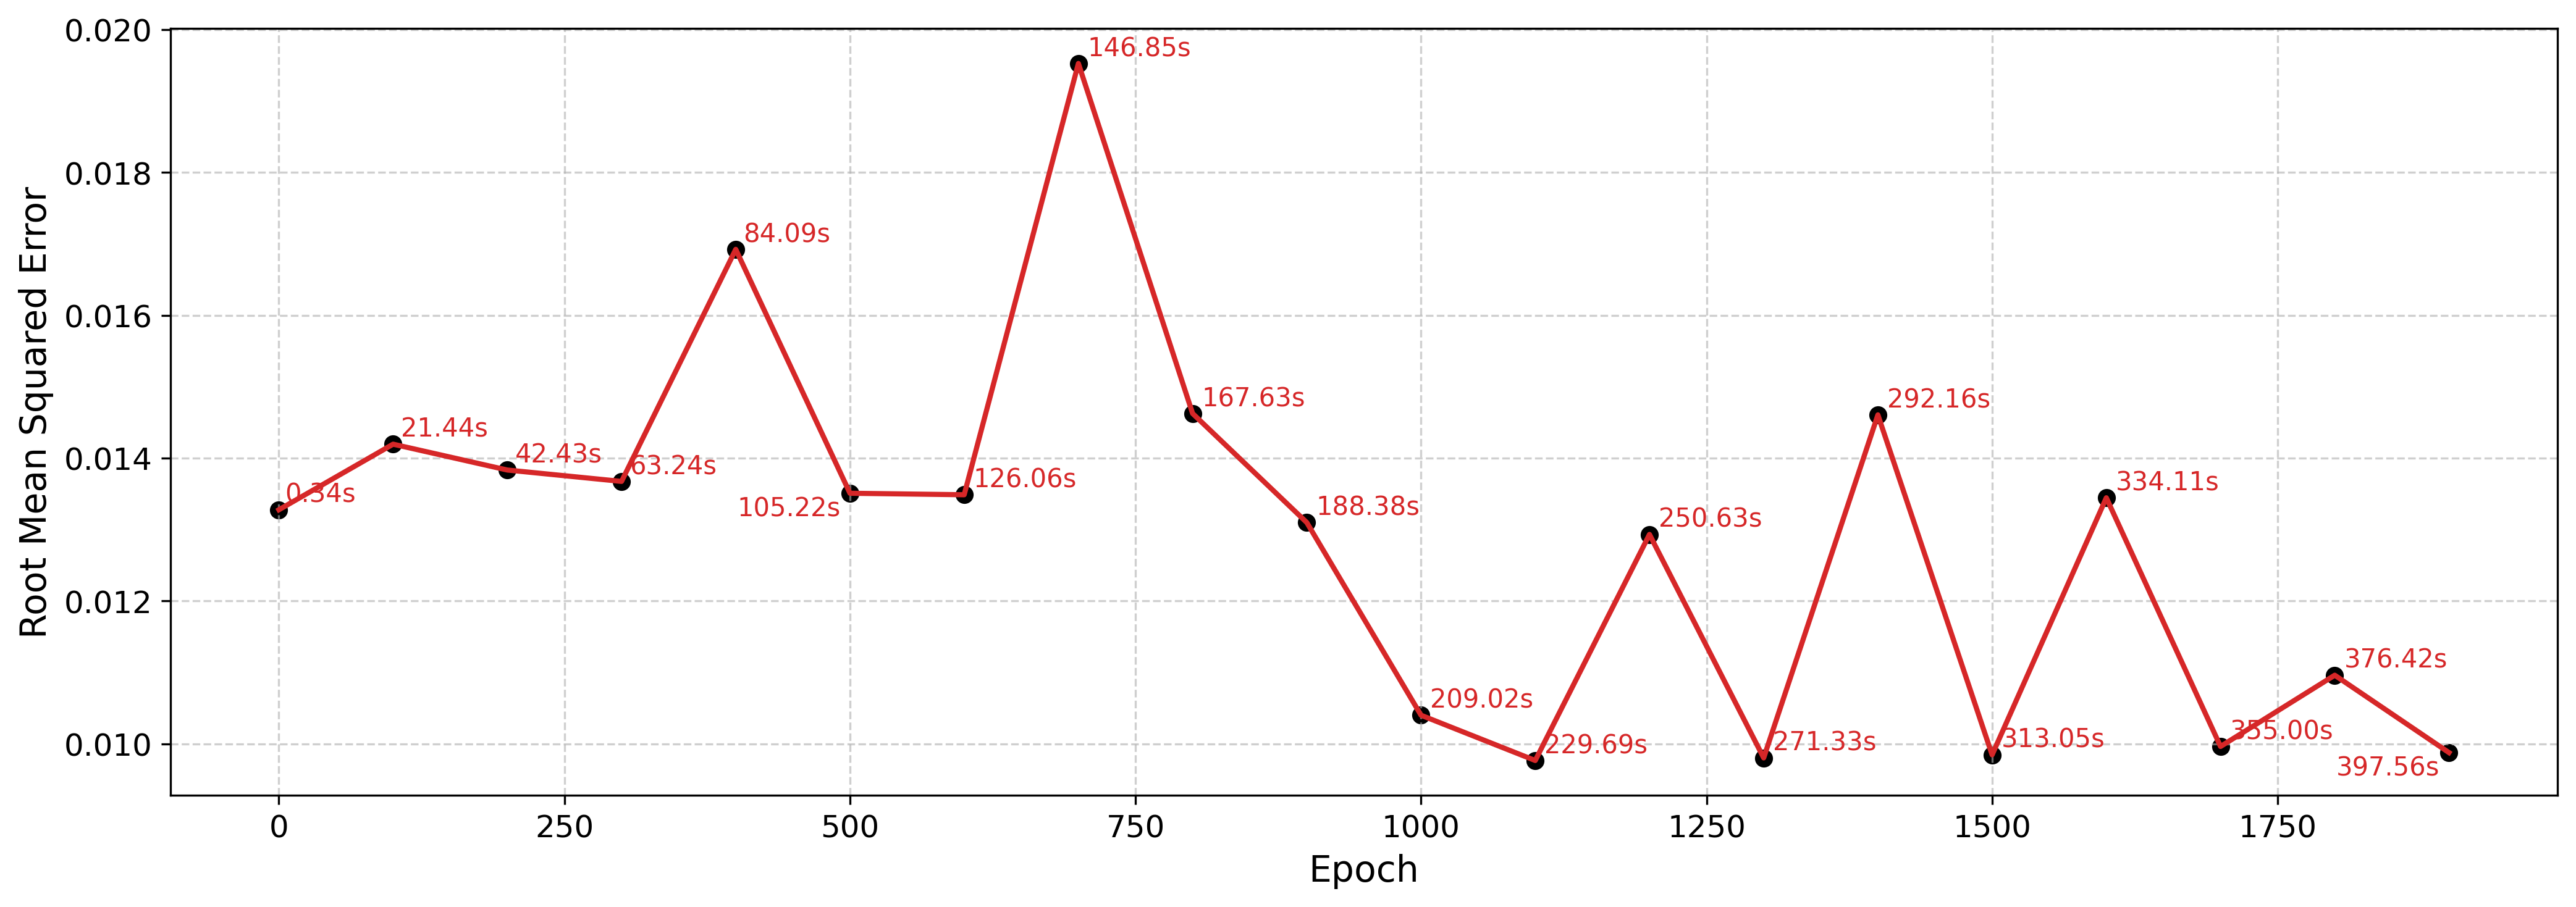

In [80]:
from matplotlib.ticker import MaxNLocator
from adjustText import adjust_text

# Load results
results = pd.read_csv("final.csv", skipinitialspace = True)

# Calculate cumulative time for each 50 epochs
cumulative_time = [sum(epoch_times[:i+1]) for i in range(0, len(epoch_times), 100)]

# Set size of the plot
fig, ax1 = plt.subplots(figsize=(14, 5), dpi=300)

color = 'tab:red'
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Root Mean Squared Error', fontsize=14)
ax1.plot(results.iloc[::100, :].index, results.iloc[::100, :]['test_accuracy'], color=color, linewidth=2)
ax1.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)

# Annotate cumulative time for each 50 epochs
texts = []
for i, (epoch, time) in enumerate(zip(results.iloc[::100, :].index, cumulative_time)):
    ax1.scatter(epoch, results.iloc[::100, :]['test_accuracy'].iloc[i], color='black')  # Add a marker at each point
    texts.append(ax1.text(epoch, results.iloc[::100, :]['test_accuracy'].iloc[i], f"{time:.2f}s",
                          ha='center', va='bottom', fontsize=10, color=color))

# Automatically adjust text positions to minimize overlaps
adjust_text(texts, expand_points=(1.15, 1.15), force_points=(1, 1))

# Add grid
ax1.grid(True, linestyle='--', alpha=0.6)

# Adjust layout for better spacing
fig.tight_layout()

# Save the figure as a high-res png
plt.savefig('Time.png', format='png', dpi=300)

#Show the plot
plt.show()


In [18]:
import seaborn as sns
sns.set(font_scale=1.2)

/Users/eduard.hogea/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/eduard.hogea/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


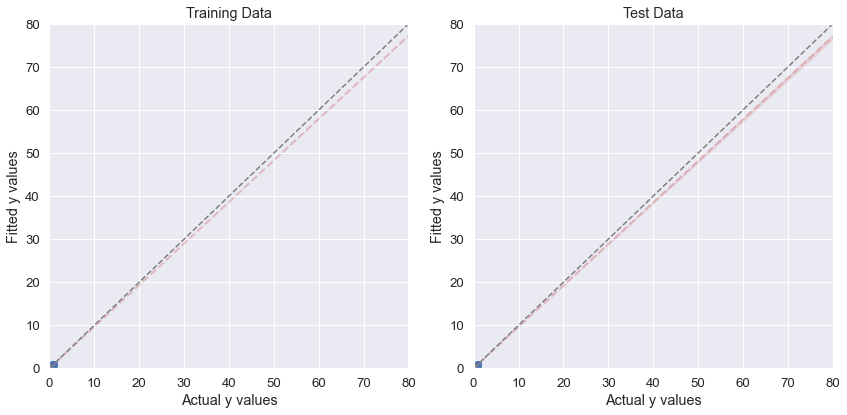

In [19]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
ax = axs[0]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_train:
    data['y_pred'].extend(f.model(x)[:,2].numpy())
    data['y_true'].extend(y[:,2].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_xlim(0,80)
ax.set_ylim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Training Data")

ax = axs[1]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_test:
    data['y_pred'].extend(f.model(x)[:,2].numpy())
    data['y_true'].extend(y[:,2].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_ylim(0,80)
ax.set_xlim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Test Data")
plt.tight_layout()
plt.savefig("LTN_regresie_1.pdf")

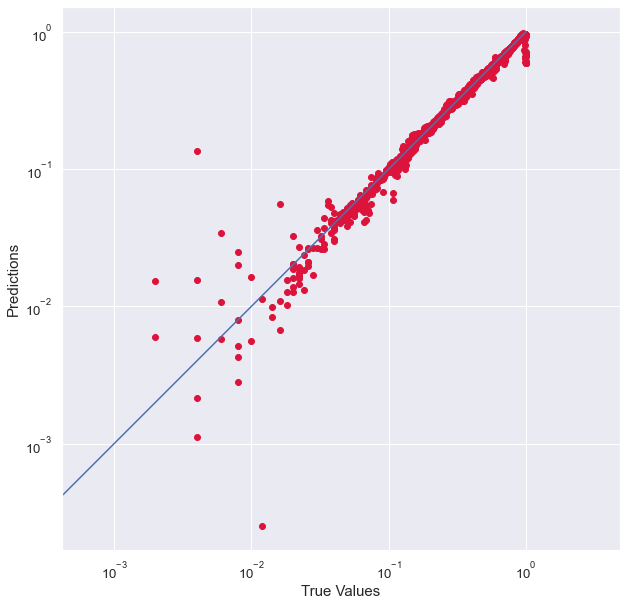

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(df['y_true'], df['y_pred'], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(df['y_pred']), max(df['y_true']))
p2 = min(min(df['y_pred']), min(df['y_true']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.savefig("LTN_regresie_final_resized.png", dpi = 300)
plt.show()

In [21]:
df = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/KNN99---LTN/datesets/Cantilever/training_sectiune/tot.csv", on_bad_lines='skip', skiprows=1)
df = df.sample(frac=1) #shuffle
x = df[['Mod 1', 'Mod 2','Mod 3','Mod 4','Mod 5','Mod 6','Mod 7','Mod 8']]
y = df[['Severitate def', 'Severitate inc.','Pozitie']]
batch_size= 32
ds_test = tf.data.Dataset.from_tensor_slices((x,y)).batch(batch_size)

data = {'y_pred':[],'y_true':[],'def':[],'inc':[]}
for x,y in ds_test:
    data['y_pred'].extend(f.model(x)[:,2].numpy())
    data['y_true'].extend(y[:,2].numpy())
    data['def'].extend(y[:,0].numpy())
    data['inc'].extend(y[:,1].numpy())
data_plot = pd.DataFrame(data,columns=['y_pred','y_true','def','inc'])
#'Severitate def', 'Severitate inc.'

In [22]:
data_plot.head(4)

,y_pred,y_true,def,inc
0,0.278224,0.278,0.066210,0.001593
1,0.511033,0.508,0.003346,0.001593
2,0.597713,0.608,0.012434,0.000413
3,0.511099,0.528,0.007105,0.000000


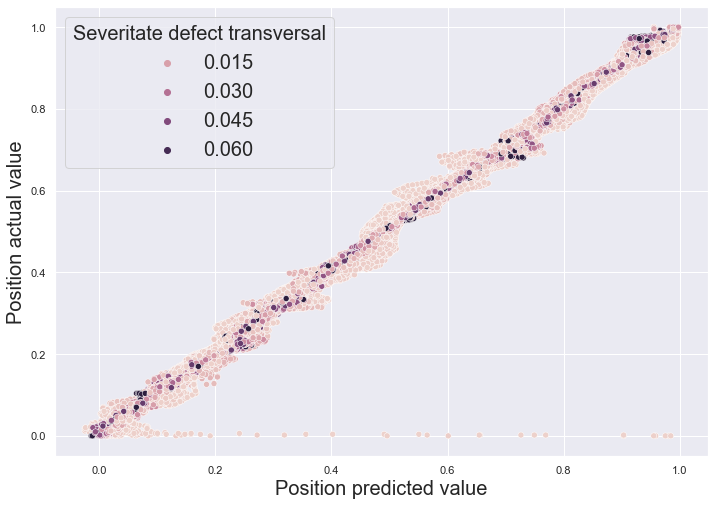

In [23]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.scatterplot(data=data_plot, x="y_pred", y="y_true", hue="def")
plt.legend(title = 'Severitate defect transversal', fontsize='20', title_fontsize='20')
plt.xlabel("Position predicted value", size=20)
plt.ylabel("Position actual value", size=20)
plt.savefig("def.png")

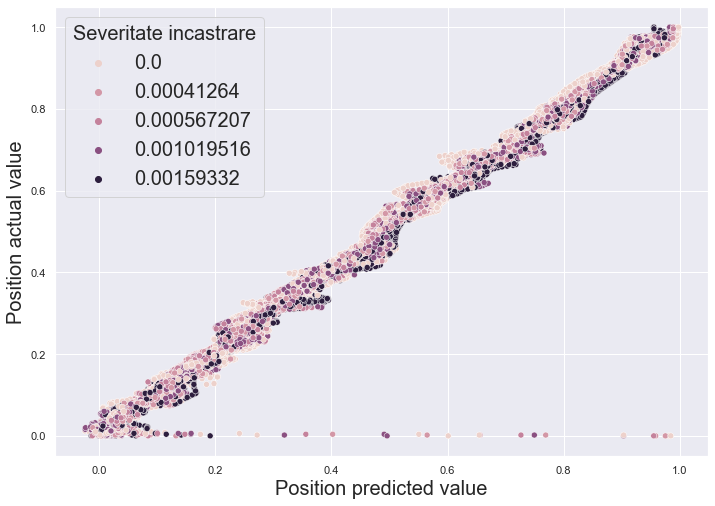

In [24]:
sns.scatterplot(data=data_plot, x="y_pred", y="y_true", hue="inc")
plt.legend(title = 'Severitate incastrare', fontsize='20', title_fontsize='20')
plt.xlabel("Position predicted value", size=20)
plt.ylabel("Position actual value", size=20)
plt.savefig("inc.png")

In [25]:
data_plot['def'].unique

<bound method Series.unique of 0        0.066210
1        0.003346
2        0.012434
3        0.007105
4        0.051453
           ...   
36568    0.009517
36569    0.001191
36570    0.032690
36571    0.026224
36572    0.000867
Name: def, Length: 36573, dtype: float64>

In [26]:
dif = abs( data_plot["y_pred"] - data_plot["y_true"])

In [27]:
index = -1
for i in dif:
    index+=1
    if i>4:
        print(i)
        print(index)

<StemContainer object of 3 artists>

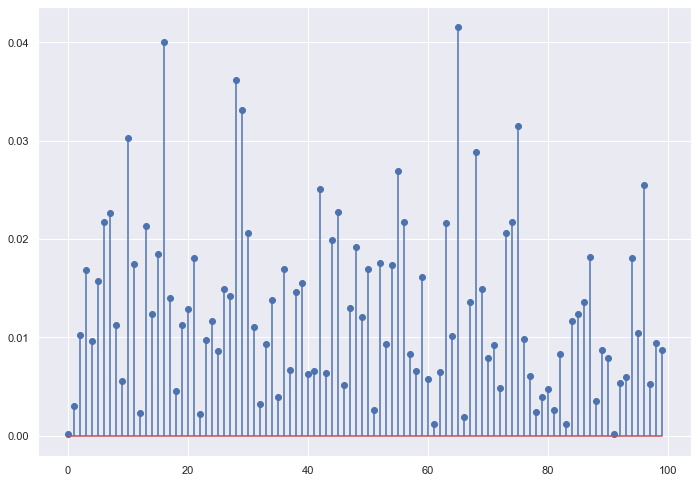

In [28]:
plt.stem(dif.head(100))

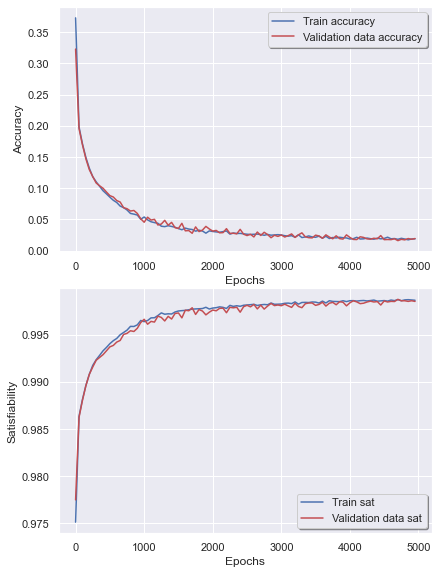

In [40]:
from pylab import rcParams
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 6, 8

results = pd.read_csv("testtest.csv", skipinitialspace = True)
fig, ax = plt.subplots(2,1)
fig.tight_layout()
#figure(figsize=(10, 6), dpi=150)
ax[0].plot(results.iloc[::50, :]['train_accuracy'], color='b', label="Train accuracy")
ax[0].plot(results.iloc[::50, :]['test_accuracy'], color='r', label="Validation data accuracy",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(results.iloc[::50, :]['train_sat'], color='b', label="Train sat")
ax[1].plot(results.iloc[::50, :]['test_sat'], color='r',label="Validation data sat")
legend = ax[1].legend(loc='best', shadow=True)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Satisfiability')

plt.savefig('my_plot.png')



In [37]:
results.iloc[::5, :]["train_accuracy"]

0       0.373079
5       0.209686
10      0.209318
15      0.208619
20      0.207824
          ...   
4975    0.019819
4980    0.017893
4985    0.018803
4990    0.018022
4995    0.018780
Name: train_accuracy, Length: 1000, dtype: float64